In [1]:
import sys
sys.path.append("/home/149/ab8992/tasman-tides/")
import xarray as xr
import ttidelib as tt
import scipy
import cmocean
import os
from pathlib import Path
cmap = cmocean.cm.dense_r
import matplotlib
import matplotlib.pyplot as plt
earth_cmap = matplotlib.colormaps["gist_earth"]
from datetime import timedelta

# import filtering
import numpy as np
import dask
dask.config.set({'logging.distributed': 'error'})
from dask.distributed import Client,default_client
import xrft



# TODO: make this a 2x3 or 3x3 plot, fix axis label fonts, esure magnitudes are sensible


In [2]:
expt = "full-20"


data = {}


for expt in ["beamless-20","smooth-20","full-20","full-10","full-40"]:
    path = Path(f"/scratch/nm03/ab8992/test/outputs") / expt
    upath = Path(f"/scratch/nm03/ab8992/test/tmpstorage") / expt
    bathy = xr.open_dataset(f"/g/data/nm03/ab8992/outputs/{expt}/bathy_transect.nc").sel(yb = slice(-120,120))
    data[expt] = xr.merge(
    [
        xr.open_dataset(upath / "u_5.nc").u,
        (xr.open_dataset(path / "EF_crossbeam_forward.nc").EF_forward + xr.open_dataset(path / "EF_crossbeam_backward.nc").EF_backward).rename("EF_across"),
        (xr.open_dataset(path / "EF_forward.nc").EF_forward + xr.open_dataset(path / "EF_backward.nc").EF_backward).rename("EF_along"),
        bathy.rename({"depth":"bathy"}) * -1
     ]
).sel(xb = slice(0,1200))



## Changes to following plot (May 14)

 - Ensure 40th degree has same phase
 - Ensure scales of quiver are consistent!
 - Show 3rd or 4th horizontal mode on differenct scale 

[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >]
beamless-20 (6,) (38,) (6, 38)
beamless-20 (6,) (38,) (6, 38)
full-20 (6,) (38,) (6, 38)
full-20 (6,) (38,) (6, 38)
smooth-20 (6,) (38,) (6, 38)
smooth-20 (6,) (38,) (6, 38)


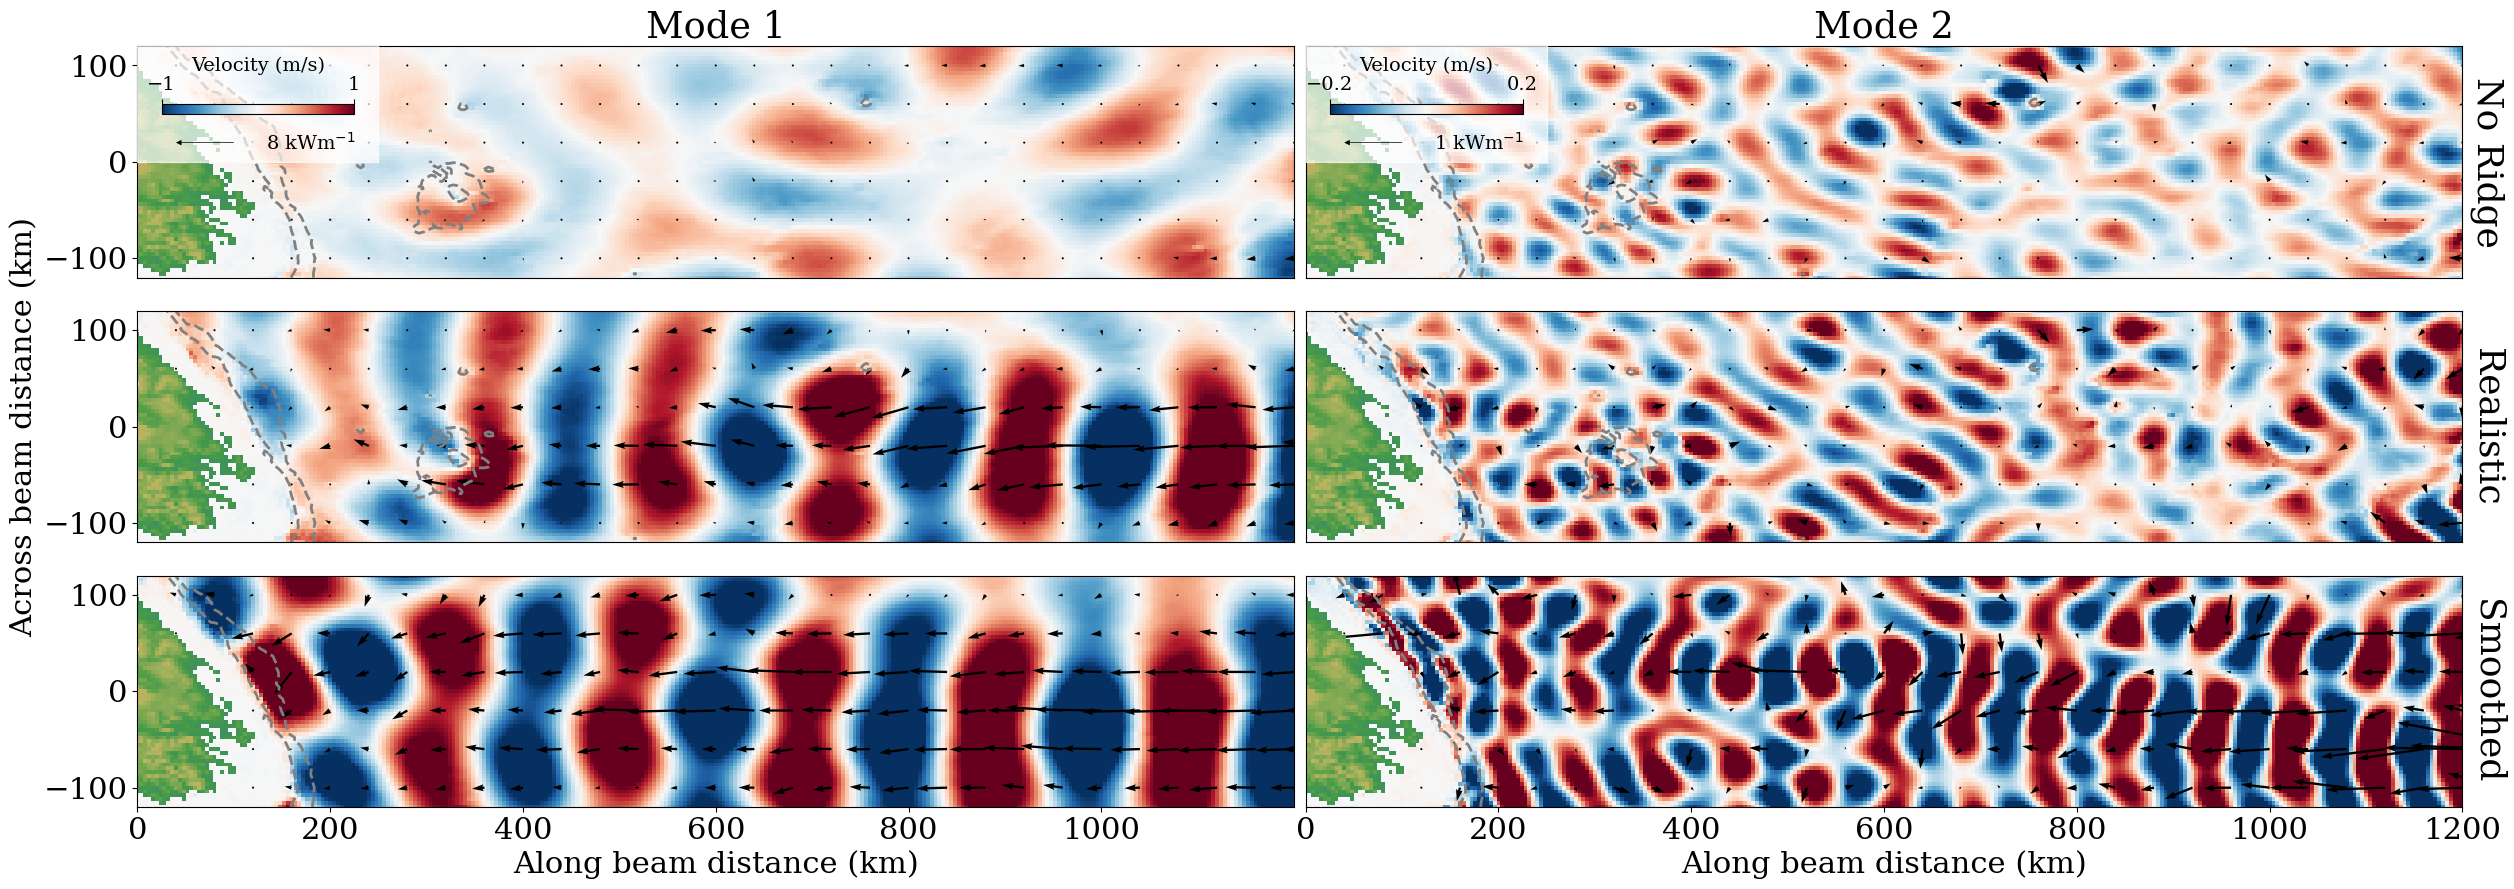

In [24]:

import matplotlib.gridspec as gridspec
font = {'family' : 'serif',
        'weight':'normal',
        'size'   : 22}
matplotlib.rc('font', **font)

def plot_KE_quiver(expt,ax,mode = 0,xlim = slice(50,250),ylim = slice(-80,80),scale = 3000,umax = 1):
    # expt = "full-20"
    alongbeam = -1 * xr.open_dataset(f"/scratch/nm03/ab8992/test/outputs/{expt}/EF_forward.nc").EF_forward - xr.open_dataset(f"/scratch/nm03/ab8992/test/outputs/{expt}/EF_backward.nc").EF_backward
    acrossbeam = xr.open_dataset(f"/scratch/nm03/ab8992/test/outputs/{expt}/EF_crossbeam_forward.nc").EF_forward + xr.open_dataset(f"/scratch/nm03/ab8992/test/outputs/{expt}/EF_crossbeam_backward.nc").EF_backward
    u = xr.open_mfdataset(f"/scratch/nm03/ab8992/test/tmpstorage/{expt}/u_*.nc").u.isel(mode = mode)
    alongbeam = alongbeam.sel(xb = xlim,yb = ylim).isel(mode = mode)
    acrossbeam = acrossbeam.sel(xb = xlim,yb = ylim).isel(mode = mode)

    if "mode" in alongbeam.dims:
        alongbeam = alongbeam.sum("mode")
        acrossbeam = acrossbeam.sum("mode")
    if "mode" in u.dims:
        u = u.sum("mode")

    # np.sqrt(acrossbeam**2 + alongbeam**2).sum("mode").plot(ax = ax)
    yspacing = 5
    xspacing = 5
    if "20" in expt:
        yspacing,xspacing = yspacing * 2, xspacing * 2
    elif "40" in expt:
        yspacing,xspacing = yspacing * 4, xspacing * 4
    _yb = acrossbeam.yb[::yspacing]
    _xb = acrossbeam.xb[::xspacing]
    _along = (alongbeam )[::yspacing,::xspacing]
    _across = (acrossbeam)[::yspacing,::xspacing]
    print(expt,_yb.shape,_xb.shape,_along.shape)

    # print(expt,np.mean(magnitude.sel(xb = slice(100,175)).values),sep = "\t")

    u.isel(time = 50).plot(ax = ax,cmap ="RdBu",add_colorbar = False,vmax = umax,vmin = -1 * umax)
    # print(magnitude)
    ax.quiver(_xb, _yb, _along, _across, color="black", scale=scale,scale_units = "width",width = 0.002)
    tt.plot_topo(ax,xr.open_dataset(f"/g/data/nm03/ab8992/outputs/{expt}/bathy_transect.nc").depth * -1)

    ax.set_ylim(-120,120)
    ax.set_xlim(0,1200)
    ax.set_xlabel("")
    ax.set_ylabel("")

fig = plt.figure(figsize = (30,10))
gs = gridspec.GridSpec(3, 2, width_ratios=[1, 1], height_ratios=[1, 1, 1],hspace = 0.1,wspace = 0.01)

ax = [fig.add_subplot(gs[i,j]) for i in range(3) for j in range(2)]
print(ax)
ax = np.array(ax).reshape(3,2)

for i,expt in enumerate(["beamless-20","full-20","smooth-20"]):
    plot_KE_quiver(expt,ax[i,0],xlim = slice(0,None),ylim = slice(-100,100),mode = 0,scale = 2000,umax = 2)
    data[expt].bathy.plot.contour(ax = ax[i,0],levels = [-2700,-1500],colors = ["grey","grey"],linestyles = "dashed",linewidths = 2)
    data[expt].bathy.plot.contour(ax = ax[i,1],levels = [-2700,-1500],colors = ["grey","grey"],linestyles = "dashed",linewidths = 2)
    plot_KE_quiver(expt,ax[i,1],xlim = slice(0,None),ylim = slice(-100,100),mode = 1,scale = 200,umax = 1)


for a in ax[:,1]:
    a.set_yticks([])
    a.set_label([])

for a in ax[0:2,:].flatten():
    a.set_xticks([])
    a.set_label([])

for a in ax.flatten():
    a.set_title("")
    a.set_xlabel("")
    a.set_ylabel("")
    # a.axis("equal")
    a.set_aspect('equal', 'box')
    a.set_xlim(0,1200)
    a.set_ylim(-120,120)


ax[0,0].set_title("Mode 1")
ax[0,1].set_title("Mode 2")
ax[1,0].set_ylabel("Across beam distance (km)")
ax[0,1].set_ylabel("No Ridge",rotation = 270,labelpad = 30)
ax[1,1].set_ylabel("Realistic",rotation = 270,labelpad = 30)
ax[2,1].set_ylabel("Smoothed",rotation = 270,labelpad = 30)
for i in range(3):
    ax[i,1].yaxis.set_label_position("right")  # Set the label position to the rightax[i,1].tick_params(axis='y', labelsize=22)  # Set font size for y-axis labels
    ax[i,0].set_yticks([-100,0,100])
    ax[i,1].yaxis.label.set_size(26)  # Set font size for y-axis labels

ax[2,0].set_xlabel("Along beam distance (km)")
ax[2,1].set_xlabel("Along beam distance (km)")


umax = 1
efmax = 8
## Add our legend
for i in range(2):
    patch = ax[0,i].add_patch(matplotlib.patches.Rectangle((0, 0), 250, 230, color='white', alpha=0.7))
    cax1 = ax[0,i].inset_axes([25, 50, 200, 10],transform=ax[0,i].transData)  # Adjust size and location
    patch.set_zorder(9)
    cax1.set_zorder(10)  # Bring the patch to the front
    cbar = plt.colorbar(
        plt.cm.ScalarMappable(cmap="RdBu_r", norm=plt.Normalize(vmin=-1 * umax, vmax=umax)),
        cax=cax1,
        orientation='horizontal',
        location = "top",
        label = "Velocity (m/s)",
    )
    cbar.set_ticks([-umax,umax])
    cax1.tick_params(labelsize=14, color="black", labelcolor="black")  # Set font size and color for colorbar ticks
    cax1.xaxis.label.set_size(14)  # Set font size for colorbar label
    cax1.xaxis.label.set_color("black")  # Set label color to black
    ax[0,i].annotate('', xy=(40, 20), xytext=(100, 20),
                arrowprops=dict(facecolor="black", width=0.5, headwidth=4, headlength = 4, edgecolor="none")).set_zorder(12)
    ax[0,i].text(180, 20, str(efmax) + r" kWm$^{-1}$", color = "black", fontsize = 14, ha = "center", va = "center").set_zorder(12)

    efmax = 1
    umax = 0.2

ax[2,0].set_xticks([0,200,400,600,800,1000])

## Show higher modes for appendix figure

[<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >]
full-10 (6,) (43,) (6, 43)
full-10 (6,) (43,) (6, 43)
full-20 (6,) (38,) (6, 38)
full-20 (6,) (38,) (6, 38)
full-40 (6,) (38,) (6, 38)
full-40 (6,) (38,) (6, 38)


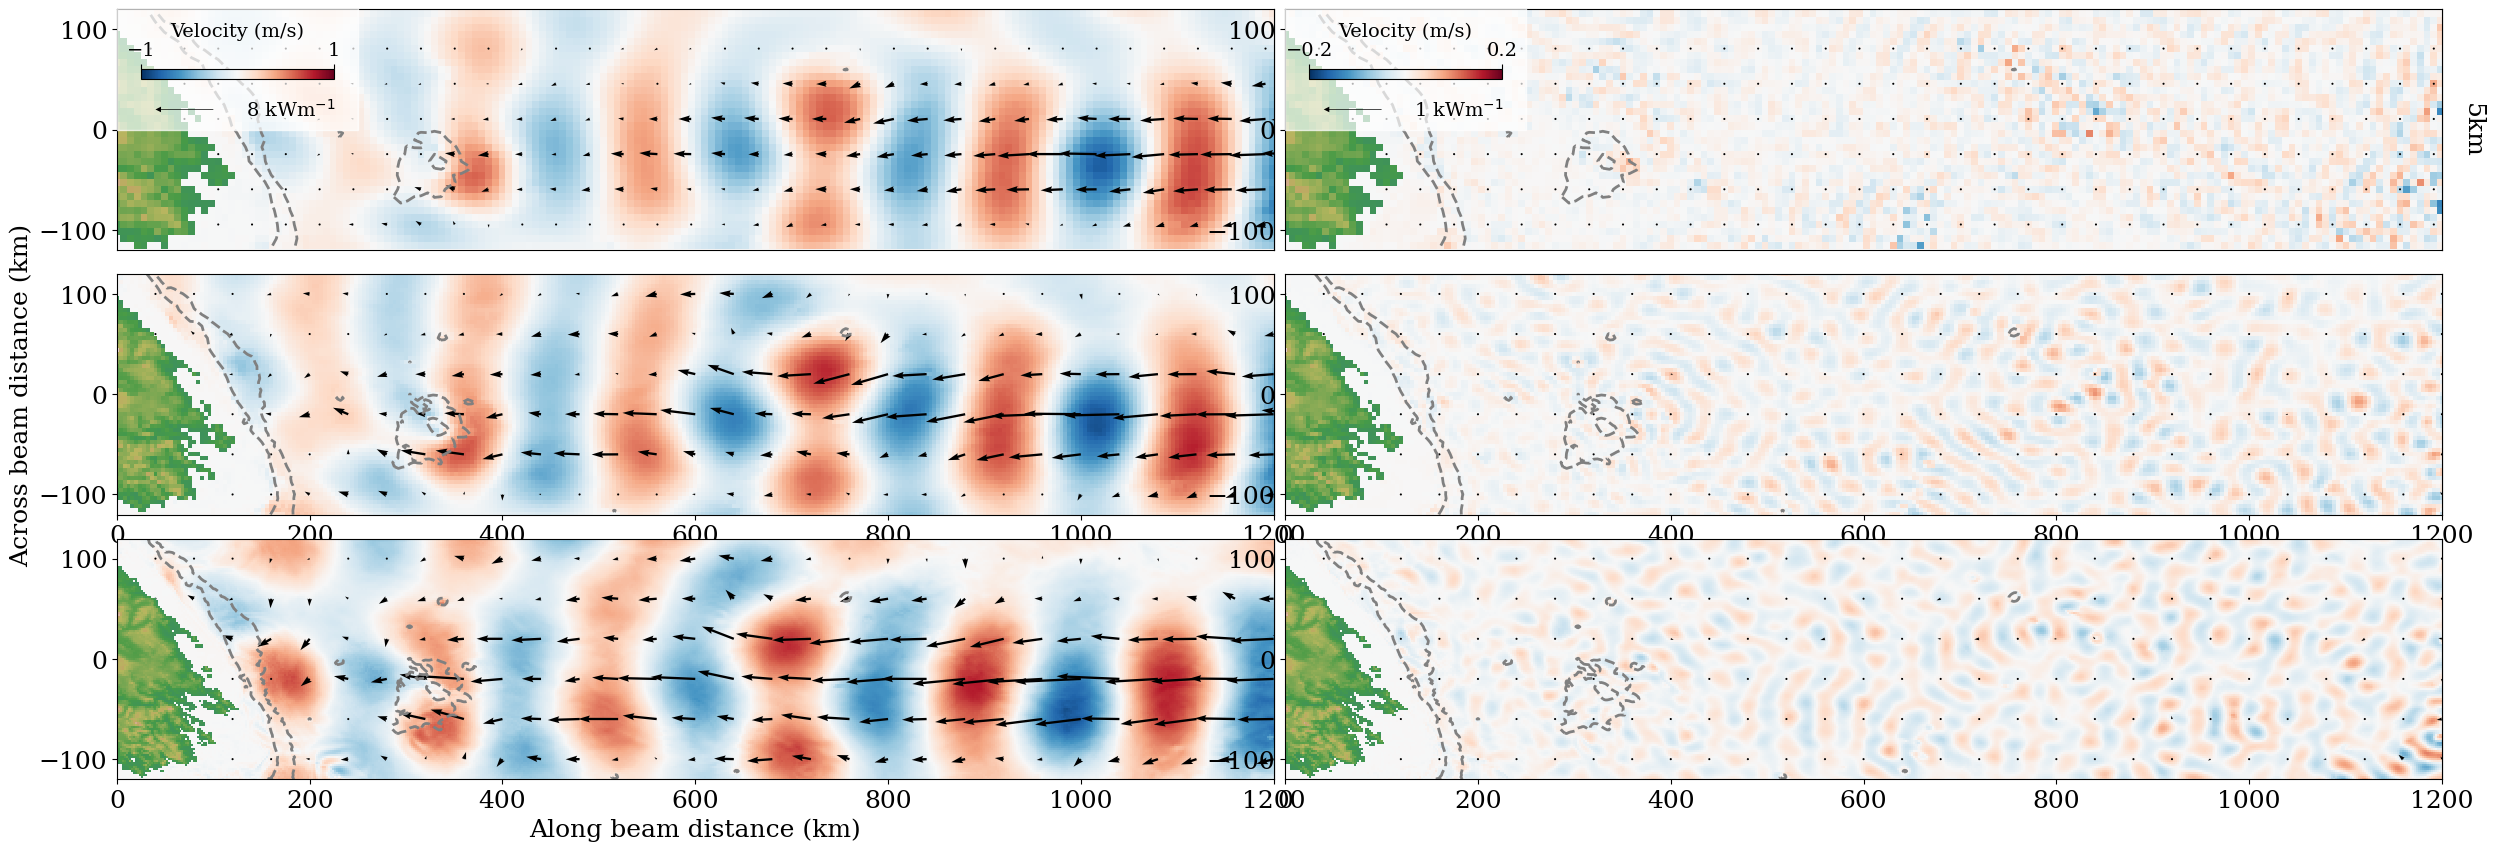

In [20]:

import matplotlib.gridspec as gridspec
font = {'family' : 'serif',
        'weight':'normal',
        'size'   : 18}
matplotlib.rc('font', **font)


fig = plt.figure(figsize = (30,10))
gs = gridspec.GridSpec(3, 2, width_ratios=[1, 1], height_ratios=[1, 1, 1],hspace = 0.1,wspace = 0.01)

ax = [fig.add_subplot(gs[i,j]) for i in range(3) for j in range(2)]
print(ax)
ax = np.array(ax).reshape(3,2)

for i,expt in enumerate(["full-10","full-20","full-40"]):
    plot_KE_quiver(expt,ax[i,0],xlim = slice(0,None),ylim = slice(-100,100),mode = 0,scale = 2000)
    data[expt].bathy.plot.contour(ax = ax[i,0],levels = [-2700,-1500],colors = ["grey","grey"],linestyles = "dashed",linewidths = 2)
    plot_KE_quiver(expt,ax[i,1],xlim = slice(0,None),ylim = slice(-100,100),mode = 3,scale = 500)
    data[expt].bathy.plot.contour(ax = ax[i,1],levels = [-2700,-1500],colors = ["grey","grey"],linestyles = "dashed",linewidths = 2)
for i,a in enumerate(ax.flatten()):
    a.set_title("")
    a.set_xlabel("")
    if i < 2:
        a.set_xticks([])
    a.set_ylabel("")
    a.set_yticks([])

    b = a.secondary_yaxis('right')
    b.set_ylabel('')
    a.set_yticks([-100,0,100])
    b.set_yticks([])
    if i == 0:
        b.set_ylabel("10km",rotation = 270,labelpad = 30)
    elif i == 1:
        b.set_ylabel("5km",rotation = 270,labelpad = 30)
    elif i == 2:
        b.set_ylabel("2km",rotation = 270,labelpad = 30)
    a.set_ylim(-120,120)


ax[0,0].set_title("")
ax[2,0].set_xlabel("Along beam distance (km)")
ax[1,0].set_ylabel("Along beam distance (km)")
ax[1,0].set_ylabel("Across beam distance (km)")

umax = 1
efmax = 8
## Add our legend
for i in range(2):
    patch = ax[0,i].add_patch(matplotlib.patches.Rectangle((0, 0), 250, 230, color='white', alpha=0.7))
    cax1 = ax[0,i].inset_axes([25, 50, 200, 10],transform=ax[0,i].transData)  # Adjust size and location
    patch.set_zorder(9)
    cax1.set_zorder(10)  # Bring the patch to the front
    cbar = plt.colorbar(
        plt.cm.ScalarMappable(cmap="RdBu_r", norm=plt.Normalize(vmin=-1 * umax, vmax=umax)),
        cax=cax1,
        orientation='horizontal',
        location = "top",
        label = "Velocity (m/s)",
    )
    cbar.set_ticks([-umax,umax])

    cax1.tick_params(labelsize=14, color="black", labelcolor="black")  # Set font size and color for colorbar ticks
    cax1.xaxis.label.set_size(14)  # Set font size for colorbar label
    cax1.xaxis.label.set_color("black")  # Set label color to black
    ax[0,i].annotate('', xy=(40, 20), xytext=(100, 20),
                arrowprops=dict(facecolor="black", width=0.5, headwidth=4, headlength = 4, edgecolor="none")).set_zorder(12)
    ax[0,i].text(180, 20, str(efmax) + r" kWm$^{-1}$", color = "black", fontsize = 14, ha = "center", va = "center").set_zorder(12)

    efmax = 1
    umax = 0.2